<a href="https://colab.research.google.com/github/marveltimothyy/Generative-Chatbot-/blob/main/Main_Code_Chatbot_With_PyTorch%5BUndergraduate_Thesis%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data and Library preparation

##Import Library and init

In [2]:
#Lib for Preprocessing and load data 
import os
from io import open
import csv
import random
import re
import unicodedata
import itertools
from sklearn.model_selection import train_test_split
import time
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
#Bleu Evaluation
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable

#Setup Cuda
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
torch.manual_seed(1)

##Load Daset 

In [4]:
import os
corpus_name = "cornell-moviedialogs-corpus"
corpus = os.path.join("/kaggle/input", corpus_name)

In [5]:
datafile = os.path.join(corpus, "formatted_movie_lines.txt")
save_dir = os.path.join("./save")

#Text Preprocessing

## Vocabulary 

In [6]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token


class Voc:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD",
                           SOS_token: "SOS",
                           EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1

## Text Preprocessing

In [ ]:
MAX_LENGTH = 10  # Maximum sentence length to consider


class TextPreprocessing:
    def unicodeToAscii(s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn')

    def normalizeString(s):
        s = TextPreprocessing.unicodeToAscii(s.lower().strip())
        s = re.sub(r"[^a-z]+", r" ", s)
        s = re.sub(r"\s+", r" ", s).strip()
        return s

    def readVocs(datafile, corpus_name):
        lines = open(datafile, encoding='utf-8').read().strip().split('\n')
        pairs = [[TextPreprocessing.normalizeString(s) for s in l.split('\t')] for l in lines]
        voc = Voc(corpus_name)
        return voc, pairs

    def filterPair(p):
        return (len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH)

    def filterPairs(pairs):
        return [pair for pair in pairs if TextPreprocessing.filterPair(pair)]

    def dropNull(pairs):
        return [pair for pair in pairs if pair[0] != '' and pair[1] != '']

    def loadPrepareData(corpus_name, datafile):
        voc, pairs = TextPreprocessing.readVocs(datafile, corpus_name)
        pairs = TextPreprocessing.filterPairs(pairs)
        pairs = TextPreprocessing.dropNull(pairs)
        for pair in pairs:
            voc.addSentence(pair[0])
            voc.addSentence(pair[1])
        return voc, pairs


voc, pairs = TextPreprocessing.loadPrepareData(corpus_name, datafile)

pairs_train, pairs_test = train_test_split(pairs, test_size=0.1, random_state=42)

#Data adjustment

In [8]:
import itertools


class DataAdjustment:
    def tokenization(voc, sentence):
        return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

    def zeroPadding(l, fillvalue=PAD_token):
        return list(itertools.zip_longest(*l, fillvalue=fillvalue))

    def dataVar(l, voc, con=True):
        indexes_batch = [DataAdjustment.tokenization(voc, sentence) for sentence in l]
        padList = DataAdjustment.zeroPadding(indexes_batch)
        padVar = torch.LongTensor(padList)
        if con:
            lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
            return padVar, lengths
        else:
            max_target_len = max([len(indexes) for indexes in indexes_batch])
            return padVar, max_target_len

    def adjustBatchData(voc, pair_batch):
        pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
        input_batch, output_batch = [], []
        for pair in pair_batch:
            input_batch.append(pair[0])
            output_batch.append(pair[1])
        inp, lengths = DataAdjustment.dataVar(input_batch, voc)
        output, max_target_len = DataAdjustment.dataVar(output_batch, voc, False)
        return inp, lengths, output, max_target_len

    def batching(batch_size, iterable):
        args = [iter(iterable)] * batch_size
        return ([e for e in t if e != None] for t in itertools.zip_longest(*args))


#Architecure Sequence-to-sequence

## ENCODER

In [9]:
# Import the necessary library.
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

class LeeOscillator():
    '''
        The Lee-Oscillator based activation function.\n
        Params:\n
            - a (list), The parameters list for Lee-Oscillator of Tanh.\n
            - b (list), The parameters list for Lee-Oscillator of Sigmoid.\n
            - K (integer), The K coefficient of the Lee-Oscillator.\n
            - N (integer), The number of iterations of the Lee-Oscillator.\n
    '''

    # Create the constructor.
    def __init__(self, a1=5, a2=5, b1=1, b2=1, K=500, N=2000, s=5, e=0.02, c=1, eu=0, ev=0, stepsize=0.002,
                 recordsize=2000):
        # Get the parameters for the Lee-Oscillator.
        self.ev = ev
        self.eu = eu
        self.a1 = a1
        self.a2 = a2
        self.b1 = b1
        self.b2 = b2
        self.K = K
        self.N = N
        self.s = s
        self.e = e
        self.c = c
        self.stepsize = stepsize
        self.recordsize = recordsize

        # Draw the bifraction diagram of the Lee-Oscillator.
        if (not os.path.exists('/kaggle/input/leeoscillator/LeeOscillator-Tanh_' + str(
                stepsize) + "_" + str(a1) + "-" + str(a2) + "-" + str(b1) + "-" + str(b2) + "-" + str(K) + "-" + str(eu) + "-" + str(ev) + '.csv')) or (
                not os.path.exists(
                    '/kaggle/input/leeoscillator/LeeOscillator-Sigmoid_' + str(stepsize) + "_" + str(a1) + "-" + str(a2) + "-" + str(
                        b1) + "-" + str(b2) + "-" + str(K) + "-" + str(eu) + "-" + str(ev) + '.csv')):
            # Compute the Lee-Oscillator.
            print("LeeOscillator is not saved, prepare to save now...")
            self.Save()
            print("LeeOscillator is saved.")
        self.tanh = torch.tensor(
            pd.read_csv(
                '/kaggle/input/leeoscillator/LeeOscillator-Tanh_' + str(stepsize) + "_" + str(a1) + "-" + str(a2) + "-" + str(b1) + "-" + str(
                    b2) + "-" + str(K) + "-" + str(eu) + "-" + str(ev) + '.csv', dtype=np.float32(), header=0,
                index_col=0).values).cuda()
        print(self.tanh)
        self.sigmoid = torch.tensor(
            pd.read_csv(
                '/kaggle/input/leeoscillator/LeeOscillator-Sigmoid_' + str(stepsize) + "_" + str(a1) + "-" + str(a2) + "-" + str(b1) + "-" + str(
                    b2) + "-" + str(K) + "-" + str(eu) + "-" + str(ev) + '.csv', dtype=np.float32(), header=0,
                index_col=0).values).cuda()
        print("LeeOscillator is loaded.")

    def CheckVal(self, x):
        if x > -1 or x < 1:
            return torch.ones(1)
        else:
            return torch.zeros(1)

    # Create the function to apply the Lee-Oscillator of tanh activation function.
    def Tanh(self, x):
        output = torch.zeros(x.shape).to(x.device)
        s = x.size()
        m = x.size(1)
        x = torch.reshape(x, (1, -1))
        cdt_1 = x > -1
        cdt_2 = x < 1
        idx = (cdt_1.int() * cdt_2.int()).bool()
        x_idx = ((x + 1) / self.stepsize).int() * idx
        y_idx = torch.randint(0, m - 1, x.size()).to(x.device) * idx
        output_1 = self.TanhGet(x_idx, y_idx)
        output_2 = (1 - idx.int()).bool() * (1 / (1 + torch.exp(- x)))
        output = output_1 + output_2

        output = torch.reshape(output, s)
        return Variable(output, requires_grad=True)

    def TanhGet(self, p, q):
        p = p.long()
        return self.tanh[p, q]

    # Create the function to apply the Lee-Oscillator of sigmoid activation function.
    def Sigmoid(self, x):
        output = torch.zeros(x.shape).to(x.device)
        s = x.size()
        m = x.size(1)
        x = torch.reshape(x, (1, -1))
        cdt_1 = x > -1
        cdt_2 = x < 1
        idx = (cdt_1.int() * cdt_2.int()).bool()
        x_idx = ((x + 1) / self.stepsize).int() * idx
        y_idx = torch.randint(0, m - 1, x.size()).to(x.device) * idx
        output_1 = self.SigmoidGet(x_idx, y_idx)
        output_2 = (1 - idx.int()).bool() * (1 / (1 + torch.exp(- x)))
        output = output_1 + output_2
        # print("output_1: ", output_1)
        # print("output_2: ", output_2)
        output = torch.reshape(output, s)
        # l = []
        # Get each value of the output.
        # for i in range(0, output.shape[0]):
        #     for j in range(0, output.shape[1]):
        #         if x[i][j] < -1 or x[i][j] > 1:
        #             output[i][j] = 1 / (1 + torch.exp(- x[i][j]))
        #         else:
        #             row = int((x[i][j] + 1) / self.stepsize)
        #             # l.append(row)
        #             col = int(np.random.rand() * (m - 1))
        #             output[i][j] = self.tanh[row][col]
        # cdt_1 = x + 1 > 0
        #
        # cdt_2 = x - 1 < 0
        # # temp_step = torch.tensor([[True], [False], [True], [True]]).cuda()
        # idx = cdt_1.int() * cdt_2.int()
        # # print((x < -1) + (x > 1)) rslt_1 = output + self.tanh[((x + 1) / self.stepsize).int().long() * idx.bool() ,
        # # int(np.random.rand() * (m - 1))] rslt_2 = 1 / (1 + torch.exp(- x)) * (1 - idx).bool() output = rslt_1 +
        # # rslt_2
        # output = torch.where(idx.bool(),
        #                      self.SigmoidGet(((x + 1) / self.stepsize), random.randint(0, m - 1), idx.bool()),
        #                      1 / (1 + torch.exp(- x)))
        # # output = idx * (self.SigmoidGet(((x + 1) / self.stepsize), torch.randint(0, m - 1, x.size()))) + \
        # #          (idx * False) * (1 / (1 + torch.exp(- x)))
        # output = (self.SigmoidGet(((x + 1) / self.stepsize) * idx, torch.randint(0, m - 1, x.size()).to(x.device) * idx)) + (1 - idx) * torch.where(x <= -1, -0.9999, 0.9999)
        # Return the output.
        # print(l)
        # torch.set_printoptions(threshold=np.inf)
        # print("SigmoidGet: ", output)
        # return Variable(output, requires_grad=True)
        return Variable(output, requires_grad=True)

    def SigmoidGet(self, p, q):
        p = p.long()
        # torch.set_printoptions(threshold=np.inf)
        # print("p: ", torch.reshape(p, (1, -1)), "q: ", torch.reshape(q, (1, -1)))
        return self.sigmoid[p, q]

    # Create the function to compute the Lee-Oscillator of tanh activation function.
    def Save(self):
        idx = 0
        recbgnidx = self.N - self.recordsize
        recofst = (self.N - self.recordsize)
        xaixs = np.zeros([(int(2 / self.stepsize)) * self.recordsize], dtype=np.float32())
        xaxisidx = 0
        Z = np.zeros([int(2 / self.stepsize), self.recordsize], dtype=np.float32())
        u = torch.zeros([self.N])
        v = torch.zeros([self.N])
        z = torch.zeros([self.N])
        w = torch.zeros([self.N])
        z[0] = 0.2
        u[0] = 0.2
        for i in np.arange(-1, 1, self.stepsize):
            sign = 0
            if i != 0:
                if i > 0:
                    sign = 1
                if i < 0:
                    sign = -1
            it = i + 0.02 * sign
            for t in range(0, self.N - 1):
                tempu = self.a1 * u[t] - self.a2 * v[t] + it - self.eu
                tempv = self.b1 * u[t] - self.b2 * v[t] - self.ev
                u[t + 1] = torch.tanh(self.s * tempu)
                v[t + 1] = torch.tanh(self.s * tempv)
                w[t + 1] = torch.tanh(self.s * torch.Tensor([it]))
                z[t + 1] = ((u[t + 1] - v[t + 1]) * np.exp(-self.K * np.power(it, 2)) + self.c * w[t + 1])
                # print(z[t + 1])
                if t >= recbgnidx:
                    xaixs[xaxisidx] = i
                    xaxisidx = xaxisidx + 1
                    Z[idx, t - recofst] = z[t + 1]
                    # print("[", idx, ",", t - recofst, "]")
            Z[idx, t - recofst + 1] = z[t + 1]
            # print(t)
            idx = idx + 1
        # print("---------------------------------------------------")
        print(Z.dtype)
        data = pd.DataFrame(Z)
        data.to_csv('./LeeOscillator-Tanh_' + str(self.stepsize) + "_" + str(self.a1) + "-" + str(self.a2) + "-" + str(
            self.b1) + "-" + str(self.b2) + "-" + str(self.K) + "-" + str(self.eu) + "-" + str(self.ev) + '.csv')
        plt.figure(1)
        fig = np.reshape(Z, [(int(2 / self.stepsize)) * self.recordsize])
        plt.plot(xaixs, fig, ',')
        plt.savefig('./LeeOscillator-Tanh.jpg')
        plt.show()

        Z = Z / 2 + 0.5
        data = pd.DataFrame(Z)
        data.to_csv(
            './LeeOscillator-Sigmoid_' + str(self.stepsize) + "_" + str(self.a1) + "-" + str(self.a2) + "-" + str(
                self.b1) + "-" + str(self.b2) + "-" + str(self.K) + "-" + str(self.eu) + "-" + str(self.ev) + '.csv')
        plt.figure(1)
        fig = np.reshape(Z, [(int(2 / self.stepsize)) * self.recordsize])
        plt.plot(xaixs, fig, ',')
        plt.savefig('./LeeOscillator-Sigmoid.jpg')
        plt.show()

In [10]:
# from Model.LeeOscillator import LeeOscillator

Lee = LeeOscillator()
class ChaoticGRU(nn.Module):
    '''
        The Chaotic Gate Recurrent Unit.\n
        Params:\n
            - inputSize (integer), The input size of the Chaotic GRU.\n
            - hiddenSize (integer), The output size of the Chaotic GRU.\n
            - Lee (LeeOscillator), The Lee-Oscillator.\n
            - chaotic (bool), The boolean to check whether use the Chaotic Mode.\n
            - bidirection (bool), The boolean to check whether apply the Bi-GRU.\n
    '''

    # Create the constructor.
    def __init__(self, inputSize, hiddenSize, Lee=None, chaotic=False, bidirection=False):
        # Create the super constructor.
        super(ChaoticGRU, self).__init__()
        # Get the member variables.
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.chaotic = chaotic
        self.bidirection = bidirection
        # Create the parameter of the input.
        self.Wi = nn.Parameter(torch.Tensor(inputSize, hiddenSize * 2).cuda())
        # Create the parameter of the hidden.
        self.Wh = nn.Parameter(torch.Tensor(hiddenSize, hiddenSize * 2).cuda())
        # Create the parameter of the bias.
        self.B = nn.Parameter(torch.Tensor(hiddenSize * 2).cuda())
        # Create the parameter of the new gate.
        self.Wni = nn.Parameter(torch.Tensor(inputSize, hiddenSize).cuda())
        self.Wnh = nn.Parameter(torch.Tensor(hiddenSize, hiddenSize).cuda())
        self.Bni = nn.Parameter(torch.Tensor(hiddenSize).cuda())
        self.Bnh = nn.Parameter(torch.Tensor(hiddenSize).cuda())
        # Check the number of directions.
        if bidirection:
            # Create the parameter of the inverse input.
            self.Winvi = nn.Parameter(torch.Tensor(inputSize, hiddenSize * 2).cuda())
            # Create the parameter of the hidden.
            self.Winvh = nn.Parameter(torch.Tensor(hiddenSize, hiddenSize * 2).cuda())
            # Create the parameter of the bias.
            self.Binv = nn.Parameter(torch.Tensor(hiddenSize * 2).cuda())
            # Create the parameter of the new gate.
            self.Wninvi = nn.Parameter(torch.Tensor(inputSize, hiddenSize).cuda())
            self.Wninvh = nn.Parameter(torch.Tensor(hiddenSize, hiddenSize).cuda())
            self.Bninvi = nn.Parameter(torch.Tensor(hiddenSize)).cuda()
            self.Bninvh = nn.Parameter(torch.Tensor(hiddenSize).cuda())
        # Initialize the parameters.
        self.initParams()
        # Create the chaotic activation function.
        self.Lee = Lee

    # Initialize the parameters.
    def initParams(self):
        # Compute the standard deviation.
        std = 1.0 / np.sqrt(self.hiddenSize)
        # Initialize the parameters.
        for param in self.parameters():
            param.data.uniform_(-std, std)

    # Create the forward propagation.
    def forward(self, x, initStates=None):
        # Get the batch size and sequence size.
        # bs, seqs, _ = x.size()
        seqs, bs, _ = x.size()
        # Create the list to store the output.
        output = []
        # Initialize the hidden.
        if initStates is None:
            if self.bidirection == True:
                ht, hinvt = (
                    torch.zeros(bs, self.hiddenSize).to(x.device), torch.zeros(bs, self.hiddenSize).to(x.device))
            else:
                ht = torch.zeros(bs, self.hiddenSize).to(x.device)
        else:
            if self.bidirection == True:
                ht, hinvt = initStates
                # print("Init: ht: ", ht, "hinvt", hinvt)
            else:
                ht = torch.cat(initStates.split(1), dim=-1).squeeze(0)
        # Compute the GRU.
        for t in range(seqs):
            # Get the xt.
            # xt = x[:, t, :]
            xt = x[t, :, :]
            # Compute the gates.
            gates = xt @ self.Wi + ht @ self.Wh + self.B
            gates = gates.float()
            # Get the value of the output.
            if self.chaotic == True:
                rt, zt = (
                    self.Lee.Sigmoid(gates[:, :self.hiddenSize]).to(x.device),
                    self.Lee.Sigmoid(gates[:, self.hiddenSize:self.hiddenSize * 2]).to(x.device)
                )
#                 rt = rt.float()
#                 zt = zt.float()
                nt = self.Lee.Tanh(xt @ self.Wni + self.Bni + rt * (ht @ self.Wnh + self.Bnh)).to(x.device)
                # Compute the hidden.
                nt = nt.float()
                ht = (1 - zt) * nt + zt * ht
            else:
                rt, zt = (
                    torch.sigmoid(gates[:, :self.hiddenSize]).to(x.device),
                    torch.sigmoid(gates[:, self.hiddenSize:self.hiddenSize * 2]).to(x.device)
                )
#                 rt = rt.float()
#                 zt = zt.float()
                nt = torch.tanh(xt @ self.Wni + self.Bni + rt * (ht @ self.Wnh + self.Bnh)).to(x.device)
                # Compute the hidden.
#                 nt = nt.float()
                ht = (1 - zt) * nt + zt * ht
            # Store the forward value.
            output.append(ht.unsqueeze(0))
        # Check the direction.
        if self.bidirection == True:
            for t in range(seqs - 1, -1, -1):
                # Get the xinvt.
                # xinvt = x[:, t, :]
                xinvt = x[t, :, :]
                # Compute the inverse gates.
                gatesInv = xinvt @ self.Winvi + hinvt @ self.Winvh + self.Binv
                gatesInv = gates.float()
                # print("hinvt: ", hinvt)
                # Get the value of the output.
                if self.chaotic == True:
                    # Get the value of each inverse gate.
                    rinvt, zinvt = (
                        self.Lee.Sigmoid(gatesInv[:, :self.hiddenSize]).to(x.device),
                        self.Lee.Sigmoid(gatesInv[:, self.hiddenSize:self.hiddenSize * 2]).to(x.device)
                    )
#                     rinvt = rinvt.float()
#                     zinvt = zinvt.float()
                    ninvt = self.Lee.Tanh(
                        xinvt @ self.Wninvi + self.Bninvi + rinvt * (hinvt @ self.Wninvh + self.Bninvh)).to(x.device)
                    # Compute the hidden.
#                     ninvt = ninvt.float()
                    hinvt = (1 - zinvt) * ninvt + zinvt * hinvt
                else:
                    rinvt, zinvt = (
                        torch.sigmoid(gatesInv[:, :self.hiddenSize]).to(x.device),
                        torch.sigmoid(gatesInv[:, self.hiddenSize:self.hiddenSize * 2]).to(x.device)
                    )
#                     rinvt = rinvt.float()
#                     zinvt = zinvt.float()
                    ninvt = torch.tanh(
                        xinvt @ self.Wninvi + self.Bninvi + rinvt * (hinvt @ self.Wninvh + self.Bninvh)).to(x.device)
                    # Compute the hidden.
#                     ninvt = ninvt.float()
                    hinvt = (1 - zinvt) * ninvt + zinvt * hinvt
                # Store the backward value.
                output[t] = torch.cat([output[t], hinvt.unsqueeze(0)], dim=2)
            # Concatenate the hidden.
            # print("ht: ", ht.size(), "hinvt", hinvt)
            ht = torch.cat([ht.unsqueeze(0), hinvt.unsqueeze(0)], dim=0)
        # Concatenate the output.
        output = torch.cat(output, dim=0)
        # Return the output and hidden.
        return output, ht

tensor([[ 0.0000, -0.9999, -0.9999,  ..., -0.9999, -0.9999, -0.9999],
        [-0.9999, -0.9999, -0.9999,  ..., -0.9999, -0.9999, -0.9999],
        [-0.9999, -0.9999, -0.9999,  ..., -0.9999, -0.9999, -0.9999],
        ...,
        [ 0.9999,  0.9999,  0.9999,  ...,  0.9999,  0.9999,  0.9999],
        [ 0.9999,  0.9999,  0.9999,  ...,  0.9999,  0.9999,  0.9999],
        [ 0.9999,  0.9999,  0.9999,  ...,  0.9999,  0.9999,  0.9999]],
       device='cuda:0')
LeeOscillator is loaded.


In [11]:
# from Model.ChaoticLSTM import ChaoticLSTM
# from Model.ChaoticGRU import ChaoticGRU


class EncoderGRU(nn.Module):
    def __init__(self, hidden_size, embedding):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = embedding
#         self.gru = nn.GRU(hidden_size,
#                           hidden_size,
#                           bidirectional=True)
        self.gru = ChaoticGRU(hidden_size, hidden_size, Lee, True, True)
#         # self.gru2 = ChaoticGRU(hidden_size, hidden_size, Lee, True, True)
#         self.rnn1 = ChaoticLSTM(hidden_size, hidden_size, Lee, True, True)
#         self.rnn2 = ChaoticLSTM(hidden_size, hidden_size, Lee, True, True)

    def forward(self, input_seq, input_lengths, hidden=None):
        embedded = self.embedding(input_seq)
        # print("In: EncoderGRU, embedded", embedded.size())
        # packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(embedded, hidden)
#         outputs1, hidden1 = self.rnn1(embedded, initStates=hidden)
#         # print("In: EncoderGRU, outputs_1*", outputs1.size(), " hidden: ", hidden1.size())
#         outputs, hidden2 = self.rnn2(embedded, initStates=hidden1)
#         (hidden1, _) = hidden1
#         (hidden2, _) = hidden2
#         hidden = torch.cat([hidden1, hidden2], dim=0)
        # hidden: [batch_size, 2, hidden_size]
        # outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # print("In: EncoderGRU, outputs_1", outputs2.size())
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        # print("In: EncoderGRU, outputs_2", outputs2.size(), " hidden: ", hidden.size())
        return outputs, hidden

## Decoder + Attention implement

In [12]:
class AttnDecoderGRU(nn.Module):
    def __init__(self, embedding, hidden_size,
                 output_size):
        super(AttnDecoderGRU, self).__init__()
        #decoder_input, decoder_hidden, encoder_outputs
        self.hidden_size = hidden_size
        self.output_size = output_size
        # Define layers
        self.embedding = embedding
#         self.gru = nn.GRU(hidden_size,
#                           hidden_size,
#                           bidirectional = False)
        self.gru = ChaoticGRU(hidden_size, hidden_size, Lee, True, False)
        # self.gru2 = ChaoticGRU(hidden_size, hidden_size, Lee, True, False)
#         self.rnn1 = ChaoticLSTM(hidden_size, hidden_size, Lee, True, False)
#         self.rnn2 = ChaoticLSTM(hidden_size, hidden_size, Lee, True, False)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # print("In: AttnDecoderGRU, input_step", input_step.size())
        embedded = self.embedding(input_step)
        # print("In: AttnDecoderGRU, embedded", embedded.size(), "hidden: ", last_hidden.size())
        # Forward through unidirectional GRU
#         h = last_hidden[-1:]
#         h = torch.cat(h.split(1), dim=-1).squeeze(0)
#         c = torch.zeros(h.size()).to(h.device)
#         current_output1, current_hidden1 = self.rnn1(embedded, initStates=(h, c))
#         gru_output, current_hidden2 = self.rnn2(embedded, initStates=current_hidden1)
#         (current_hidden1, _) = current_hidden1
#         (current_hidden2, _) = current_hidden2
#         hidden = torch.cat([current_hidden1, current_hidden2], dim=0)
        gru_output, hidden = self.gru(embedded, last_hidden)
        hidden = hidden.unsqueeze(0)
        # print("In: AttnDecoderGRU, gru_output", gru_output.size(), "hidden: ", hidden.size())
        # Calculate attention weights from the current GRU output
        luong_dot_score = torch.sum(gru_output * encoder_outputs, dim=2)
        attn_energies = luong_dot_score.t()
        attn_weights = F.softmax(attn_energies, dim=1).unsqueeze(1)

        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))

        gru_output = gru_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((gru_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))

        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # print("In: AttnDecoderGRU, output", output.size(), " hidden: ", hidden.size())
        return output, hidden

#Train-Test Step

## Train step

In [13]:
def train(input_variable, lengths, target_variable, max_target_len,
          encoder, decoder, embedding, encoder_optimizer, decoder_optimizer,
          batch_size, clip, max_length=MAX_LENGTH):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    lengths = lengths.to("cpu")

    loss = 0
    print_losses = []

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
    # print("In: train, encoder_outputs", encoder_outputs.size(), " encoder_hidden: ", encoder_hidden.size())
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # decoder_hidden = encoder_hidden
    decoder_hidden = encoder_hidden[:1]
    # print("In: train, decoder_input", decoder_input.size(), " decoder_hidden: ", decoder_hidden.size())
    # Forward batch of sequences through decoder one time step at a time
    for t in range(max_target_len):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden, encoder_outputs
        )
        # print("In: train, decoder_output", decoder_output.size(), " decoder_hidden: ", decoder_hidden.size())
        # Teacher forcing: next input is current target
        decoder_input = target_variable[t].view(1, -1)
        # Calculate and accumulate loss
        decoder_output = torch.log(decoder_output)
        mask_loss = criterion(decoder_output,
                              target_variable[t])
        loss += mask_loss
        print_losses.append(mask_loss.item())

    loss.backward()

    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / max_target_len

##Test Step **EVALUATION**

In [14]:
def test(input_variable, lengths, target_variable, max_target_len,
         encoder, decoder, embedding, encoder_optimizer, decoder_optimizer,
         batch_size, clip, max_length=MAX_LENGTH):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    lengths = lengths.to("cpu")

    loss = 0
    print_losses = []

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    decoder_hidden = encoder_hidden[:1]

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor(
                [[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            decoder_output = torch.log(decoder_output)
            mask_loss = criterion(decoder_output,
                                  target_variable[t])
            loss += mask_loss
            print_losses.append(mask_loss.item())

    encoder.train()
    decoder.train()
    return sum(print_losses) / max_target_len




---
#Result


---



##Save State for (1536-128-15-0.0001)

In [15]:
hidden_size = 1536
batch_size = 512
epoch = 50
learning_rate = 0.0001
clip = 50.0
teacher_forcing_ratio = 1.0
loss_list = []
start_iteration = 1
print_loss = 0

torch.manual_seed(1)

print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)

# Initialize encoder & decoder models
encoder = EncoderGRU(hidden_size, embedding)
decoder = AttnDecoderGRU(embedding,
                         hidden_size,
                         voc.num_words)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss(ignore_index=PAD_token, reduction='mean')

train_batch = list(DataAdjustment.batching(batch_size, pairs))
training_batches = [DataAdjustment.adjustBatchData(voc,
                                                   [train_batch[j][i]
                                                    for i in range(len(train_batch[j]))])
                    for j in range(len(train_batch) - 1)]

for ep in range(epoch):
    random.shuffle(training_batches)
    print("Epoch {}".format(ep + 1))
    since = time.time()
    #data train session
    for iteration in range(start_iteration, len(train_batch) - 1):
        training_batch = training_batches[iteration - 1]

        input_variable, lengths, target_variable, max_target_len = training_batch

        loss = train(input_variable, lengths, target_variable,
                     max_target_len, encoder, decoder, embedding,
                     encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss
        loss_list = print_loss
        print("\tIteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / (
                    len(train_batch) - 1) * 100, print_loss))
        print_loss = 0
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
# Save checkpoint
# directory = os.path.join(save_dir)
# if not os.path.exists(directory):
#     os.makedirs(directory)
# torch.save({
#     'en': encoder.state_dict(),
#     'de': decoder.state_dict(),
#     'en_opt': encoder_optimizer.state_dict(),
#     'de_opt': decoder_optimizer.state_dict(),
#     'voc_dict': voc.__dict__,
#     'embedding': embedding.state_dict()
# }, os.path.join(directory, '3{}-{}-{}-{}.tar'.format(hidden_size, batch_size, epoch, learning_rate)))

Building encoder and decoder ...
Building optimizers ...
Epoch 1
	Iteration: 1; Percent complete: 0.6%; Average loss: 10.0775
	Iteration: 2; Percent complete: 1.2%; Average loss: 9.5886
	Iteration: 3; Percent complete: 1.8%; Average loss: 9.1043
	Iteration: 4; Percent complete: 2.4%; Average loss: 8.5771
	Iteration: 5; Percent complete: 3.0%; Average loss: 8.2158
	Iteration: 6; Percent complete: 3.7%; Average loss: 7.5219
	Iteration: 7; Percent complete: 4.3%; Average loss: 7.4407
	Iteration: 8; Percent complete: 4.9%; Average loss: 7.2498
	Iteration: 9; Percent complete: 5.5%; Average loss: 7.4514
	Iteration: 10; Percent complete: 6.1%; Average loss: 7.1267
	Iteration: 11; Percent complete: 6.7%; Average loss: 7.0941
	Iteration: 12; Percent complete: 7.3%; Average loss: 6.8820
	Iteration: 13; Percent complete: 7.9%; Average loss: 6.9245
	Iteration: 14; Percent complete: 8.5%; Average loss: 6.7678
	Iteration: 15; Percent complete: 9.1%; Average loss: 6.4531
	Iteration: 16; Percent comp

In [36]:
directory = os.path.join(save_dir)
if not os.path.exists(directory):
    os.makedirs(directory)
torch.save({
    'en': encoder.state_dict(),
    'de': decoder.state_dict(),
    'en_opt': encoder_optimizer.state_dict(),
    'de_opt': decoder_optimizer.state_dict(),
    'voc_dict': voc.__dict__,
    'embedding': embedding.state_dict()
}, os.path.join(directory, '3{}-{}-{}-{}.tar'.format(hidden_size, batch_size, epoch, learning_rate)))

In [29]:
class DecoderPredict(nn.Module):
    def __init__(self, encoder, decoder):
        super(DecoderPredict, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # print("In: DecoderPredict, encoder", encoder_outputs.size())
        decoder_hidden = encoder_hidden[:1]
        decoder_input = torch.ones(1, 1, device=device,
                                   dtype=torch.long) * SOS_token
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        for _ in range(max_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input,
                                                          decoder_hidden,
                                                          encoder_outputs)
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        return all_tokens, all_scores

In [32]:
encoder.eval()
decoder.eval()
searcher = DecoderPredict(encoder, decoder)


class InputProcessing:
    def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
        indexes_batch = [DataAdjustment.tokenization(voc, sentence)]
        lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
        input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
        input_batch = input_batch.to(device)
        lengths = lengths.to("cpu")
        tokens, scores = searcher(input_batch, lengths, max_length)
        decoded_words = [voc.index2word[token.item()] for token in tokens]
        return decoded_words

    def response_only(input_sentence):
        input_sentence = TextPreprocessing.normalizeString(input_sentence)
        output_words = InputProcessing.evaluate(encoder, decoder, searcher, voc, input_sentence)
        outword = []
        for i in output_words:
            if i == 'EOS' or i == 'PAD':
                break
            else:
                outword.append(i)
        return ' '.join(outword)

In [35]:
def set_response():
    input_list = ['can play music?', 'Hello', 'how are you?', 'can you smile?', 'good morning', 'what is your name?',
                  'are you okay?', 'thanks', 'can you help me?', 'do you love me?', 'what are you doing?', 'i love you',
                  'good night', 'bye']
    out_dict = {}
    for i in input_list:

        input_sentence = TextPreprocessing.normalizeString(i)
        output_words = InputProcessing.evaluate(encoder, decoder, searcher, voc, input_sentence)

        outword = []
        for j in output_words:
            if j == 'EOS':
                break
            elif j != 'PAD':

                outword.append(j)
        string = ' '.join(outword)
        string = re.sub(' ll ', "'ll ", string)
        string = re.sub(' t ', "'t ", string)
        string = re.sub(' d ', "'d ", string)
        string = re.sub(' re ', "'re ", string)
        string = re.sub(' s ', "'s ", string)
        string = re.sub(' m ', " am ", string)
        string = re.sub(' ve ', "'ve ", string)
        out_dict[i] = string

    for j in input_list:
        print("Human :", j)
        print("Bot   :", out_dict[j])


set_response()

Human : can play music?
Bot   : i can't do that
Human : Hello
Bot   : you're gonna miss
Human : how are you?
Bot   : i am fine thank you
Human : can you smile?
Bot   : i am sorry
Human : good morning
Bot   : good morning
Human : what is your name?
Bot   : what's the name
Human : are you okay?
Bot   : i am fine
Human : thanks
Bot   : i am not
Human : can you help me?
Bot   : i am sorry
Human : do you love me?
Bot   : i love you
Human : what are you doing?
Bot   : i am a couple of you
Human : i love you
Bot   : i love you
Human : good night
Bot   : what's the matter
Human : bye
Bot   : it's not the time


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


[10.0775, 9.5886, 9.1043, 8.5771, 8.2158, 7.5219, 7.4407, 7.2498, 7.4514, 7.1267, 7.0941, 6.882, 6.9245, 6.7678, 6.4531, 6.3733, 6.4782, 6.2591, 6.2406, 6.1328, 6.0914, 5.7903, 5.6738, 5.7362, 5.753, 5.4188, 5.5298, 5.514, 5.222, 5.2196, 5.2316, 5.183, 5.2734, 4.9131, 4.9808, 5.2626, 4.9335, 4.7166, 5.0146, 5.1043, 4.9793, 5.0552, 5.1083, 4.8642, 5.2142, 4.757, 5.0235, 5.1366, 4.9216, 4.7974, 4.9777, 4.832, 4.9562, 5.0977, 5.0594, 5.0392, 5.1625, 5.0264, 4.7894, 5.1104, 4.7547, 4.9819, 5.0361, 4.9847, 5.2434, 5.0304, 4.8629, 4.9632, 4.8315, 4.6675, 4.924, 5.0575, 5.0185, 5.0343, 4.9611, 5.0167, 4.8652, 4.9415, 5.0991, 4.7392, 4.9136, 4.9076, 4.822, 4.8688, 4.9149, 5.0101, 5.0259, 4.9786, 4.7356, 4.7537, 4.9933, 4.8665, 4.6744, 4.6805, 4.8667, 4.8898, 4.8375, 4.7533, 4.9314, 4.5306, 4.7159, 4.2782, 4.7179, 4.7952, 4.9864, 4.9688, 4.4272, 4.7984, 4.3622, 4.8916, 4.7973, 4.6957, 4.6942, 4.6647, 4.8398, 4.8696, 4.8055, 4.8519, 4.6655, 5.4398, 4.6722, 4.6986, 4.5879, 4.7164, 4.5308, 4.8653,

In [47]:
loss_list =np.loadtxt("loss_WithLee.txt", delimiter="\n")
loss_list = loss_list.tolist()
# print(loss_list.tolist())
epoch_loss = []
temp_loss = []
index = 1
for loss in loss_list:
    temp_loss.append(loss)
    if index % 163 == 0:
        sum(temp_loss)
        average=sum(temp_loss)/len(temp_loss)
        epoch_loss.append(average)
    index = index + 1
print(epoch_loss)

[5.209196319018404, 4.852907055214727, 4.669097955010225, 4.542418251533738, 4.444779877300614, 4.364167791411041, 4.294033654688869, 4.231540184049078, 4.174948670756648, 4.122667300613499, 4.073460290016731, 4.026981850715743, 3.982441151486544, 3.9396420683610796, 3.898346789366047, 3.8584788343558225, 3.819651100685667, 3.781865576005446, 3.745147336131732, 3.709331073619621, 3.6744740870581243, 3.6405347183491235, 3.60727522005867, 3.5749374744376183, 3.543328957055204, 3.512577937706452, 3.482382685753225, 3.452898488168262, 3.4241346308440783, 3.3959524744376206, 3.36840267168018, 3.3414903182515237, 3.3151251161925916, 3.289291104294467, 3.2640023312883306, 3.2391916155419134, 3.214985425302597, 3.1912026638682542, 3.167879770331911, 3.1449925613496843, 3.1225868322609545, 3.1005835378323043, 3.0789334855186112, 3.057673842721691, 3.036811533742326, 3.0163207388636923, 2.996178318757337, 2.976453796012264, 2.957013359208706, 2.9378783435582747]


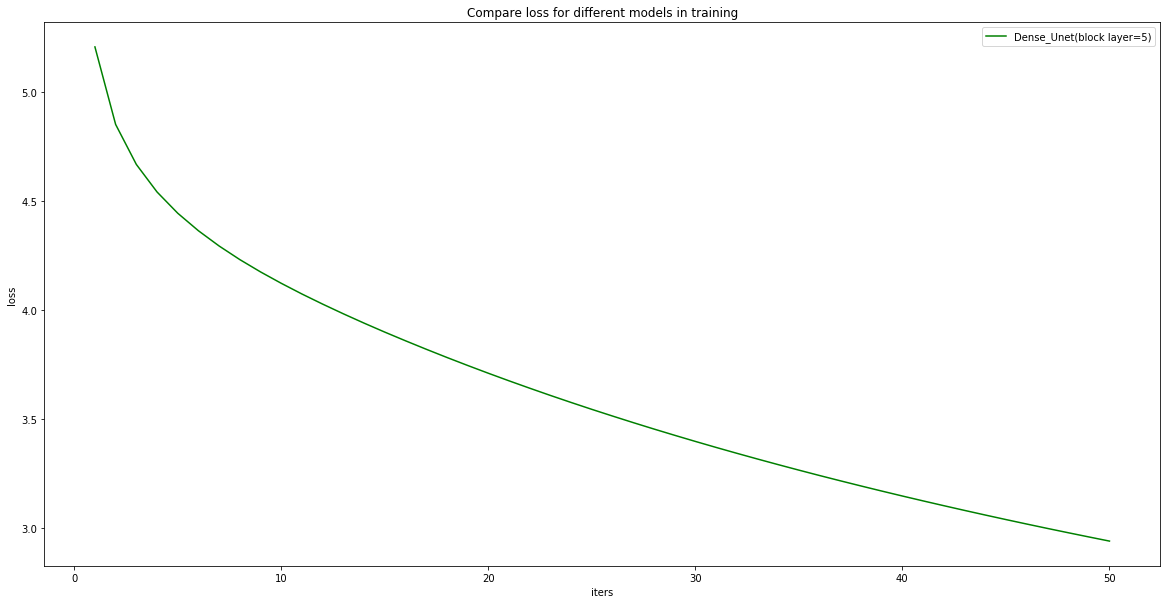

In [49]:
x = epoch_loss
y = range(1,len(epoch_loss)+1)
fig = plt.figure(figsize = (20, 10), dpi=72)
# ax1 = fig.add_subplot(1, 1, 1)
pl.plot(y,x,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
# p2 = pl.plot(x1, y1,'r-', label = u'RCSCA_Net')
pl.legend()
#显示图例
# p3 = pl.plot(x2,y2, 'b-', label = u'SCRCA_Net')
# pl.legend()
import matplotlib.ticker as ticker
pl.xlabel(u'iters')
pl.ylabel(u'loss')
plt.title('Compare loss for different models in training')
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(163))
plt.savefig("train_results_loss.png")
# pl.show

In [ ]:
x = loss_list.tolist()
y = range(1,len(x)+1)
fig = plt.figure(figsize = (50, 20), dpi=72)
# ax1 = fig.add_subplot(1, 1, 1)
pl.plot(y,x,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
# p2 = pl.plot(x1, y1,'r-', label = u'RCSCA_Net')
pl.legend()
#显示图例
# p3 = pl.plot(x2,y2, 'b-', label = u'SCRCA_Net')
# pl.legend()
import matplotlib.ticker as ticker
pl.xlabel(u'iters')
pl.ylabel(u'loss')
plt.title('Compare loss for different models in training')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(163))
plt.savefig("train_results_loss_epoch_with.png")
# pl.show

In [26]:
import re
f = open("WithLee.txt", "r", encoding='utf-8')     #打开test.txt文件，以只读得方式，注意编码格式，含中文
data = f.readlines()                            #循环文本中得每一行，得到得是一个列表的格式<class 'list'>
f.close()                                       #关闭test.txt文件
for line in data:
    result = re.match('.*Average loss: ([\d.]+)',line)     #使用正则表达式筛选每一行的数据,自行查找正则表达式
    if result is not None:
        t = (result.group(1))                        #group(1)将正则表达式的(\d.*\d)提取出来
        f1 = open("loss_WithLee.txt", "a+", encoding='utf-8')        #新建一个test1.txt文本，已追加的方式写入
        f1.write(t+'\n')                                      #将每一行打印进test1.txt文件并换行
f1.close()

In [24]:
import re
reg_loss = r"(?<=Average loss: )[0-9.]+"
result = re.match(".*Average loss: ([\d.]+)","Average loss: 10.0775")
print(result.group(1))

10.0775
